In [10]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [162]:
import numpy as np
import matplotlib.pyplot as pl
from corner import hist2d
from astropy.table import Table
from tqdm import tqdm_notebook

# An Interactive Introduction to Supervised Learning
## Pierre Gratier
### Laboratoire d'Astrophysique de Bordeaux

<br>
<div align="left">
<img src="images/logo_3DICE.png" style="width:200px"/>
<img src="images/vignette-lab.png" style="width:200px" />
</div>



# Machine learning 
0. Choose a quantity to optimize. For regression, one of:
     - Mean squared errors
     - Median absolute deviation
1. Train
     - Use a large fraction of the dataset (the larger, and more diverse, the better)
2. Validate hyperparameters
     - make sure not to overtrain
     - cross validation (eg train on 2/3 of training set, test on 1/3. Repeat 3 times)
3. Test
     - On *previously unseen* data
4. (interpret)

# But train with what ???

Whatever you want !

- linear models
- polynomials
- neural networks
- ...

# Supervised machine learning

Predict an output property knowning a set of input parameters
 - if property is discrete : classification
 - if property is continuous : regression 
 
![regression_tools.png](images/regression_tools.jpeg)

# Decision Trees
<br>
<div align="left">
<img src="images/Treebeard.png.jpeg" style="width:600px"/>
</div>


# Decision Trees
 - non linear machine learning algorithm
 - Can be used for classification or regression
 - Don't need to "prepare" (eg normalise, reparametrize) data
<br>
<div align="left">
<img src="images/decisiontree.gif" style="width:600px"/>
</div>

In [307]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
def nonlinfunc(x):
    return np.sinc(x)

def create_trainset(ntrain=20,ntest=1000,noise=0.):
    xmin, xmax = -3, 3
    x_true = np.linspace(xmin-2,xmax+2,ntest)
    x_train = np.random.uniform(xmin, xmax, ntrain)
    y_true = nonlinfunc(x_true)
    y_train = nonlinfunc(x_train)
    y_train += np.random.normal(0,noise,ntrain)
    return x_train, y_train, x_true, y_true

def plot_depth(idepth, **kwargs):
    pl.plot(xtest,ytrue,'k-',label="original function")
    pl.plot(xtrain,ytrain,'C0.',label='train')
    reg_eg = DecisionTreeRegressor(max_depth=idepth)
    reg_eg.fit(xtrain.reshape(-1,1), ytrain)
    pred = reg_eg.predict(xtest.reshape(-1,1))
    pl.plot(xtest,pred,'r-',label='learned function')
    rmse = np.sqrt(((ytrue-pred)**2).mean())
    pl.title("#samples={}, max depth={}, RMSE={:5.3f}".format(len(xtrain),idepth, rmse))
    pl.legend(loc='upper left')
    pl.show()

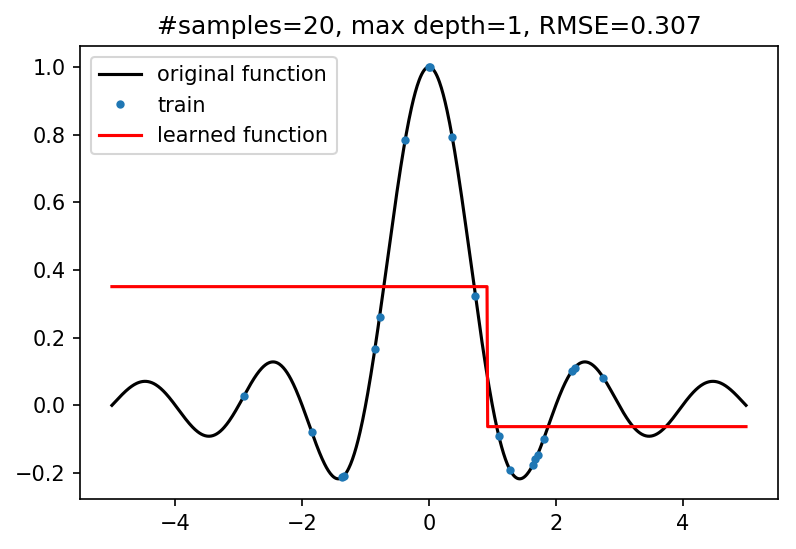

In [308]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset()
plot_depth(1)

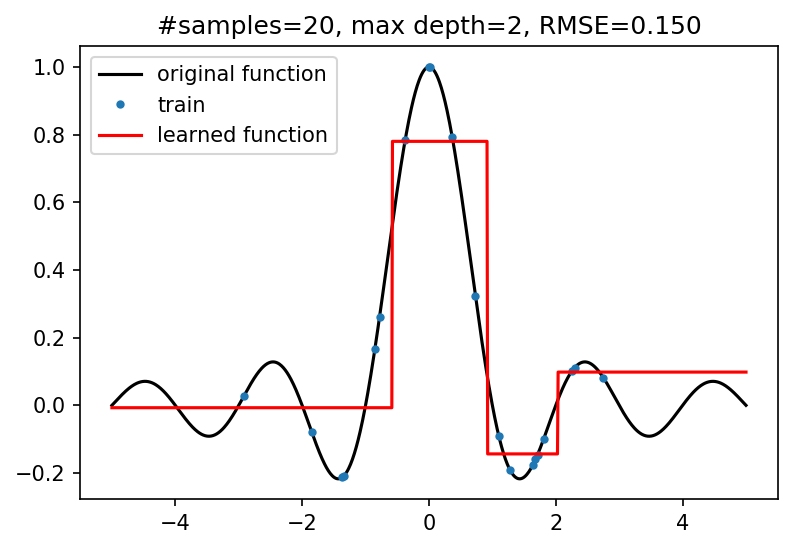

In [309]:
plot_depth(2)

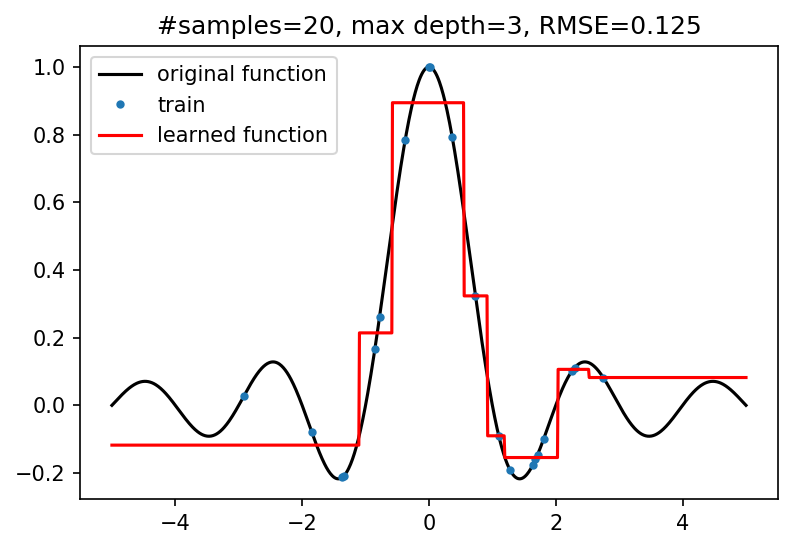

In [310]:
plot_depth(3)

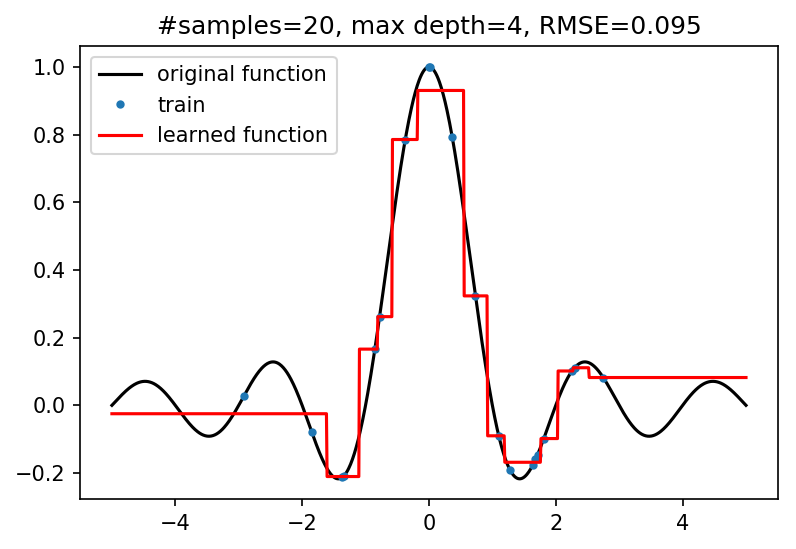

In [311]:
plot_depth(4)

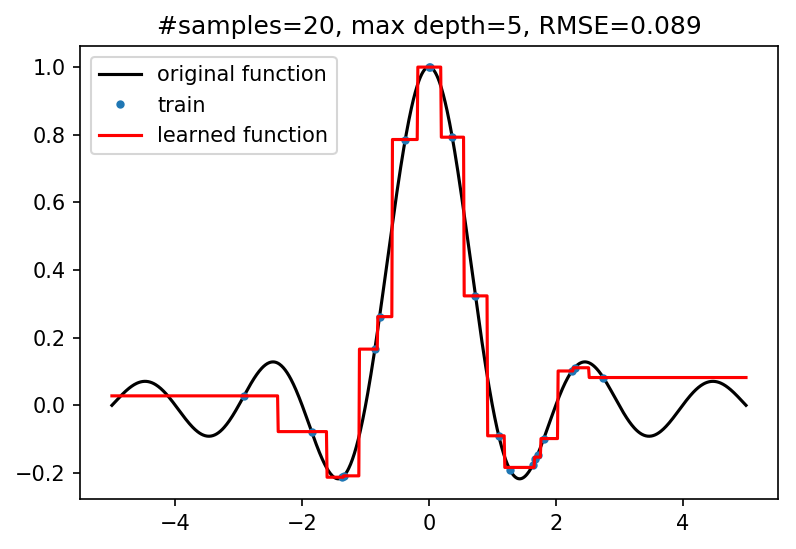

In [312]:
plot_depth(5)

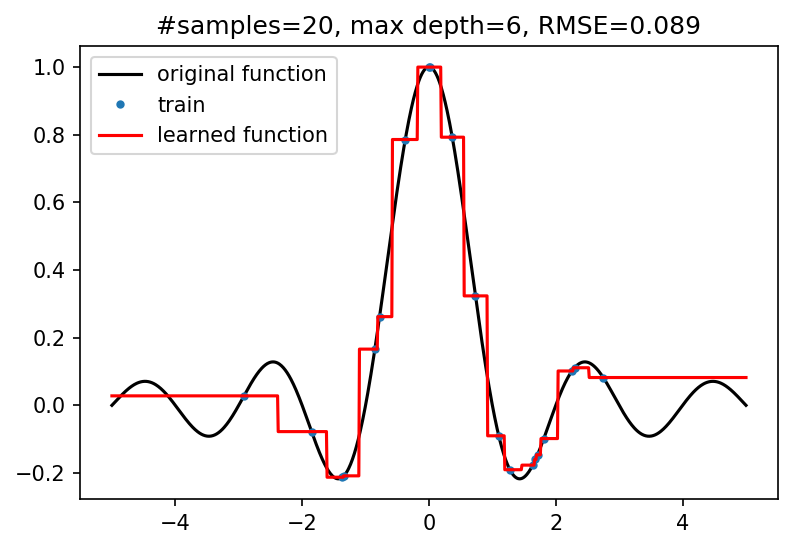

In [313]:
plot_depth(6)

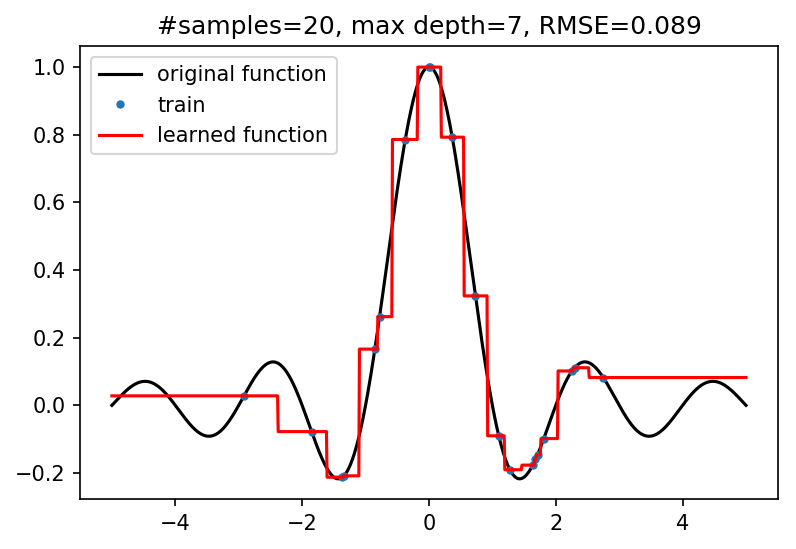

In [314]:
plot_depth(7)

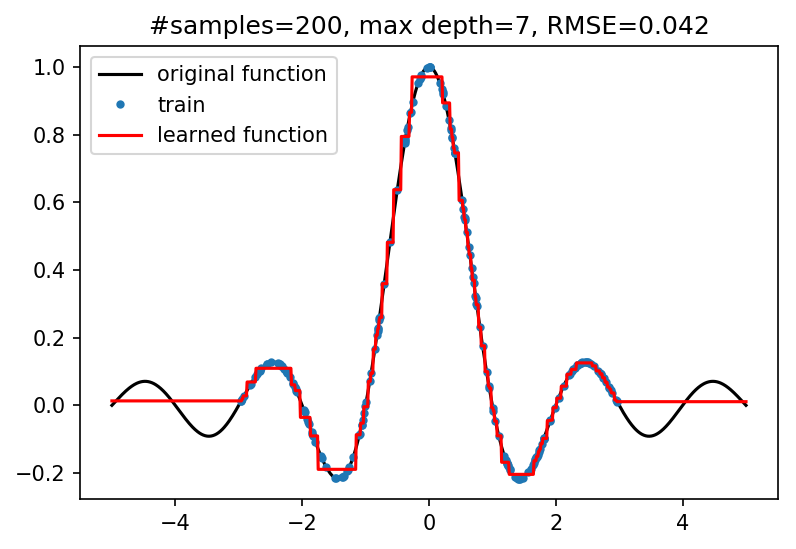

In [315]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(ntrain=200)
plot_depth(7)

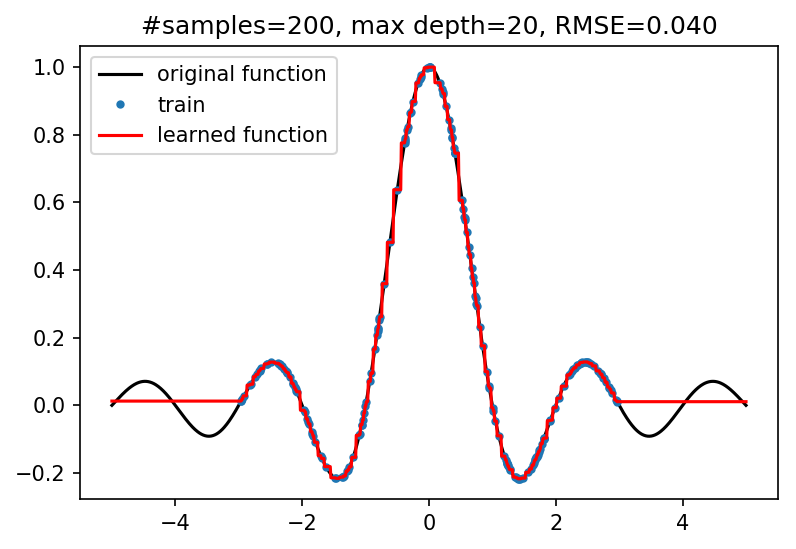

In [316]:
plot_depth(20)

# What about noise ?

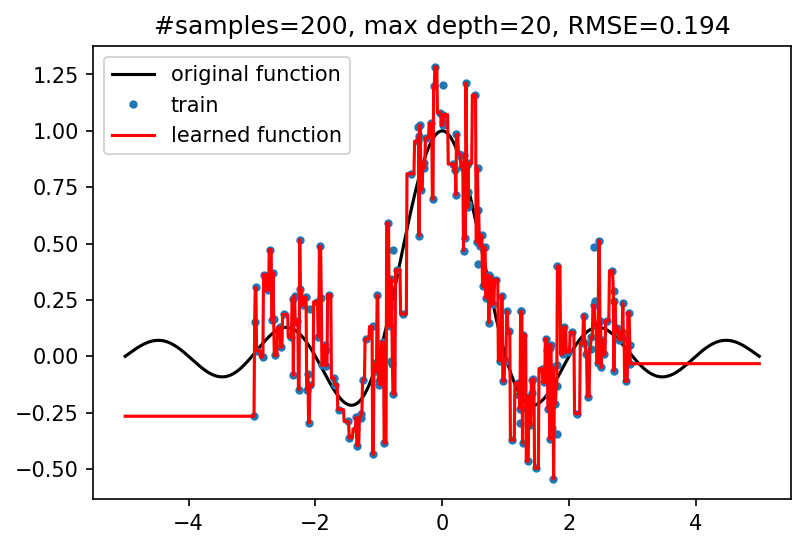

In [317]:
np.random.seed(1234)
xtrain, ytrain, xtest, ytrue = create_trainset(ntrain=200, noise=0.2)
plot_depth(20)

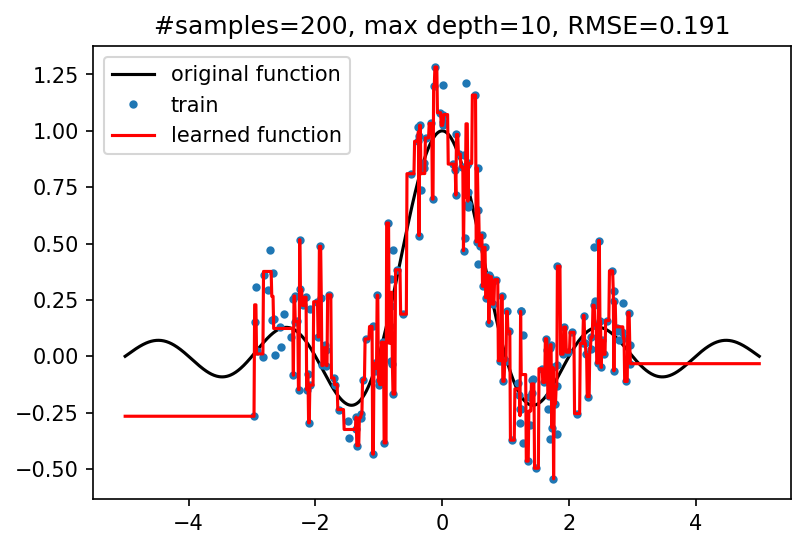

In [318]:
plot_depth(10)

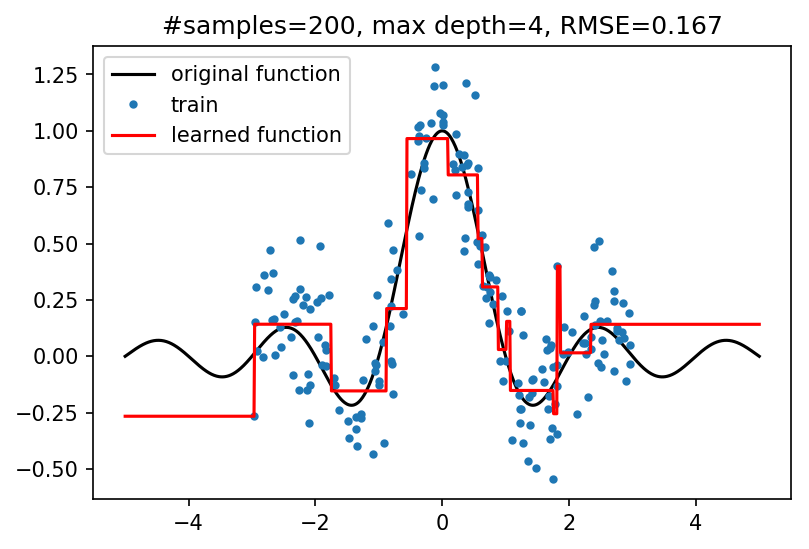

In [319]:
plot_depth(4)

# You enter the forest ... 
<br>
<div align="left">
<img src="images/forest.jpg" style="width:600px"/>
</div>

# The Random Forest
Idea:
 - train a bunch of weaker trees on random subsets of the data
     - less deep
     - only considering a subset of the features
     - ** to minimise sensitivity to overtraining**
 - average their results out 
 
Generalised to bagging methods (="bootstrap aggreggating")
 - a lot of "weak" learners can be bagged


In [320]:
def plot_depth_random_forest(idepth):
    pl.plot(xtest,ytrue,'k-',label="original function")
    pl.plot(xtrain,ytrain,'C0.',label='train')
    rf = RandomForestRegressor(500,max_depth=idepth)
    rf.fit(xtrain.reshape(-1,1), ytrain)
    pred = rf.predict(xtest.reshape(-1,1))
    for tree in rf.estimators_[:100]:
        pl.plot(xtest,tree.predict(xtest.reshape(-1,1)),'C1-',alpha=0.1)
    pl.plot(xtest,tree.predict(xtest.reshape(-1,1)),'C1-',alpha=0.1,label='individual trees')
    pl.plot(xtest,pred,'r-',label='average of trees')
    rmse = np.sqrt(((ytrue-pred)**2).mean())
    pl.title("#samples={}, max depth={}, RMSE={:5.3f}".format(len(xtrain),idepth, rmse))
    pl.legend(loc='upper left')

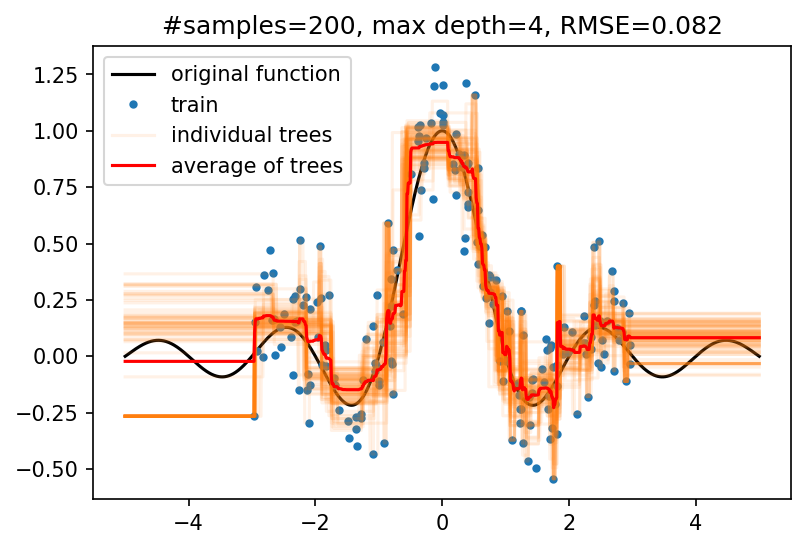

In [321]:
plot_depth_random_forest(4)

# Random forests recap


# Photometric reshift example

Estimate redshift of a galaxie without having to record a full spectrum

In [145]:
t = Table.read('data/dataset.dat', format='ascii.commented_header')
X = np.array([t['r_mag'], t['(u-g)'], t['(g-r)'], t['(r-i)'], t['(i-z)']]).T
y = np.array(t['specz'])
t

objID,r_mag,(u-g),(g-r),(r-i),(i-z),specz,specz_err,r_mag_err,(u-g)_err,(g-r)_err,(r-i)_err,(i-z)_err
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1237645879573873373,20.103556,0.61777878,1.5659828,0.80243492,0.34698868,0.50467163,0.00020466947,0.12190636211279779,0.7569993424418415,0.1856641077267804,0.08918345792766323,0.16939028255106794
1237645941824356668,19.704782,1.289072,1.1333313,0.51053619,0.41262436,0.36670265,6.5150554e-05,0.0655080060003986,0.33961256317629146,0.05978348297217164,0.0364401446169884,0.06327843123851273
1237645942898230100,20.193981,0.65864944,1.6796875,0.97254181,0.42072105,0.51120573,9.6673393e-05,0.06894538211721137,0.4696232662930288,0.13246810970813222,0.04741867468974273,0.07219557530687769
1237645943434969247,17.664146,2.3386784,1.3168621,0.52295685,0.30891609,0.2178527,2.8101276e-05,0.034146275497393484,0.2086004253407079,0.017263574133549436,0.010426318102097713,0.016662031474130867
1237645943973609779,20.679634,2.8722134,1.285862,0.78954506,0.42936516,0.53021437,0.00012953312,0.08482012218868118,0.9404929344359603,0.14391915658624657,0.07034844106473559,0.10070183666858297
1237646586638631776,17.648102,1.2305584,0.77993202,0.39781952,0.19709969,0.12130364,1.3130572e-05,0.04140241865153553,0.2656704256725191,0.03141473544805958,0.020330210959204627,0.036698848342571165
1237646586638696975,17.390694,1.8147697,0.99510956,0.45385933,0.34827614,0.12077779,2.1676848e-05,0.0404870914021047,0.4983410051472198,0.03283435383999303,0.018127467166179162,0.027556321567178722
1237646586639287212,18.276638,0.63219833,1.3370743,0.44069099,0.32370758,0.27851638,3.7723737e-05,0.09077032654908011,1.2388604557839884,0.17696659585781443,0.06197666372981022,0.09387934854518722
1237646587173340066,17.29701,1.1269169,0.68570518,0.26628304,0.2367115,0.15302545,3.2831675e-05,0.04995095286032848,0.08662077996581817,0.017630657351227326,0.016086336565440434,0.03967631810790787


# Having a look at the data

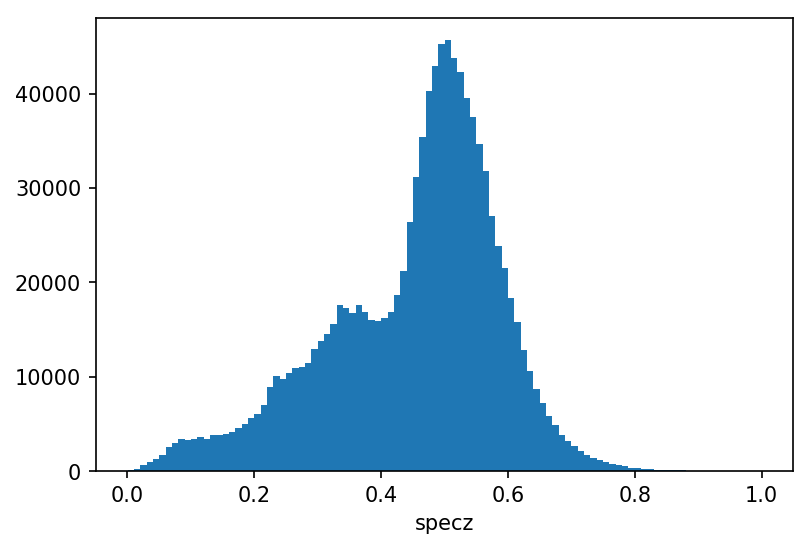

In [124]:
pl.hist(y, bins=100)
pl.xlabel('specz')
pl.show()

# Having a look at the data

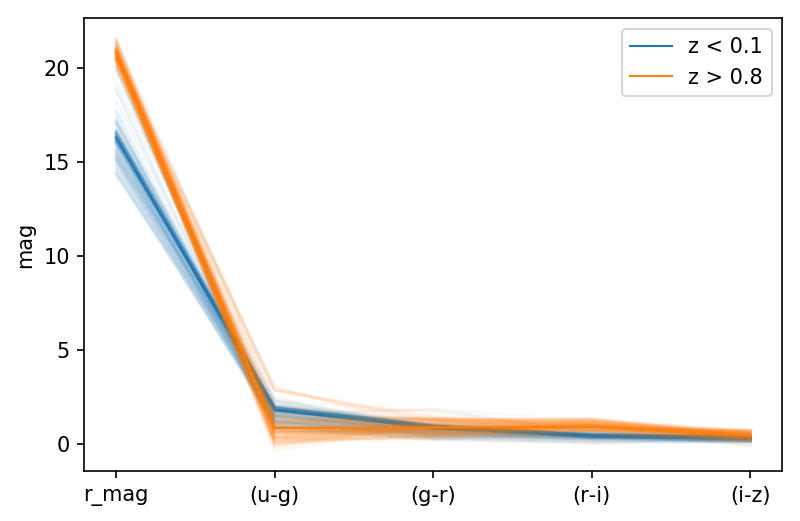

In [125]:
#low z
lowz = X[y<0.1]
for z in lowz[:100]:
    pl.plot(z,'C0',alpha=0.05)
pl.plot(np.mean(lowz,0),'C0',lw=1,label='z < 0.1')
#high z
highz = X[y>0.8]
for z in highz[:100]:
    pl.plot(z,'C1',alpha=0.05)
pl.plot(np.mean(highz,0),'C1',lw=1,label='z > 0.8')
pl.ylabel('mag')
pl.xticks([0,1,2,3,4],t.colnames[1:])
pl.xticks
pl.legend()
pl.show()

# Check that linear models don't work

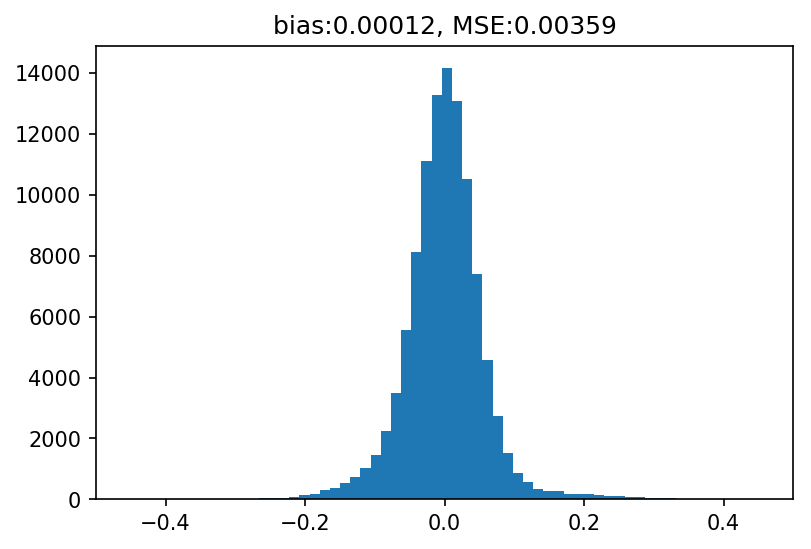

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)
reg = LinearRegression()
reg.fit(X_train,y_train)
y_pred = reg.predict(X_test)

diff = y_pred-y_test
pl.hist(diff, bins=100)
pl.xlim([-0.5,0.5])
pl.title("bias:{:6.5f}, MSE:{:4.5f}".format(np.mean(diff), np.std(diff)**2))
pl.show()

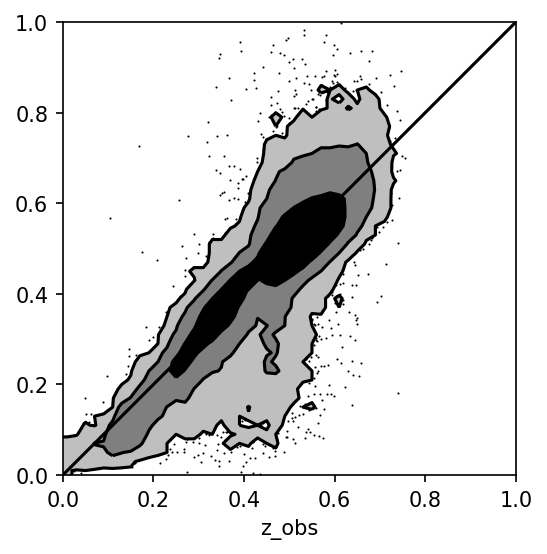

In [132]:
fig, ax = pl.subplots()
hist2d(y_pred,y_test,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_xlabel("z_pred")
ax.set_xlabel("z_obs")
pl.plot([0,1],[0,1],'k-')

In [129]:
from sklearn.ensemble import RandomForestRegressor 
rf = RandomForestRegressor(n_estimators=10,max_features='auto',max_depth=10,n_jobs=8, verbose=False, oob_score=False)
# %time fit = rf.fit(X_train, y_train)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error)



In [130]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'max_features': [1, 2, 3, 4, 5], 
#    'max_depth': range(1,20,2)
  },
 ]
GridSearchR = GridSearchCV(rf,param_grid,scoring=mse_scorer,cv=5,verbose=1,n_jobs=8,return_train_score=True)
GridSearchR.fit(X_train, y_train)



Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed:  2.8min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=8,
           oob_score=False, random_state=None, verbose=False,
           warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid=[{'max_features': [1, 2, 3, 4, 5]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error), verbose=1)

In [133]:
# print(GridSearchR.cv_results_)
param = GridSearchR.cv_results_['param_max_features'].data
mean_train = GridSearchR.cv_results_['mean_train_score']
mean_test = GridSearchR.cv_results_['mean_test_score']
std_train = GridSearchR.cv_results_['std_train_score']
std_test = GridSearchR.cv_results_['std_test_score']
param

array([1, 2, 3, 4, 5], dtype=object)

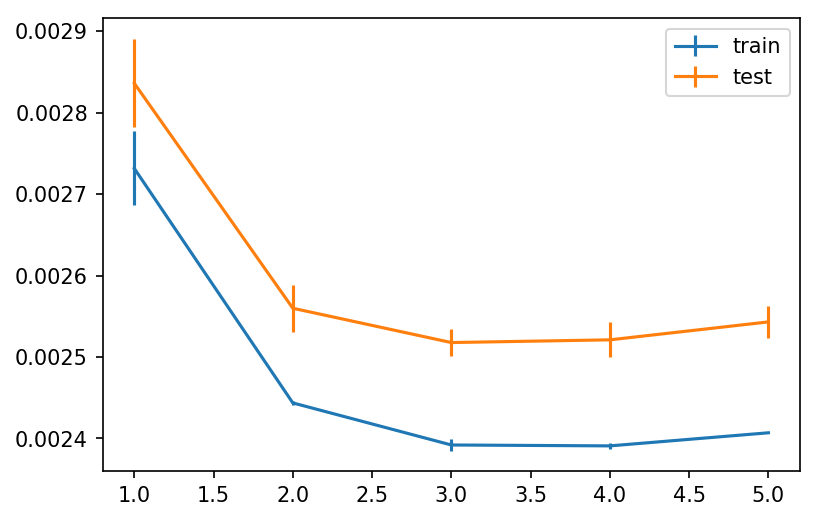

In [134]:
pl.errorbar(param,mean_train,std_train,label='train')
pl.errorbar(param,mean_test,std_test,label='test')
pl.legend()

In [30]:
from sklearn.model_selection import GridSearchCV
param_grid = [
  {
   'max_features': [1, 2, 3, 4, 5], 
   'max_depth': range(1,20,2)
  },
 ]
GridSearchR = GridSearchCV(rf,param_grid,scoring=mse_scorer,cv=5,verbose=1,n_jobs=8,return_train_score=True)
GridSearchR.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   56.6s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.6min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=5, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=8, oob_score=False, random_state=None,
           verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid=[{'max_features': [1, 2, 3, 4, 5], 'max_depth': range(1, 20, 2)}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(mean_squared_error), verbose=1)

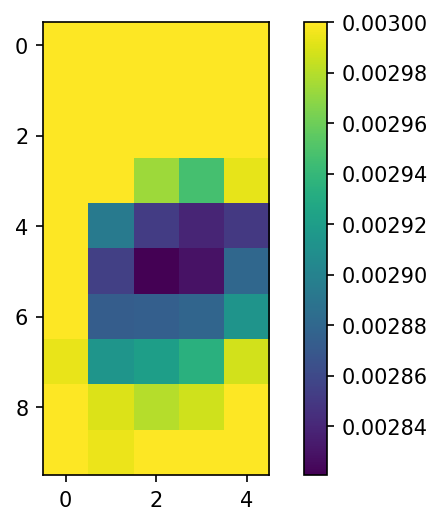

In [31]:
param = GridSearchR.cv_results_['param_max_features'].data
mean_train = GridSearchR.cv_results_['mean_train_score']
mean_test = GridSearchR.cv_results_['mean_test_score']
std_train = GridSearchR.cv_results_['std_train_score']
std_test = GridSearchR.cv_results_['std_test_score']

pl.imshow(mean_test.reshape(-1,5),vmax=0.003)
pl.colorbar()

In [32]:
%time y_pred = rf.predict(X_test)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error)
rf.score


CPU times: user 16.4 ms, sys: 3.86 ms, total: 20.3 ms
Wall time: 108 ms


Text(0.5,1,'bias:0.00012, MSE:0.00359')

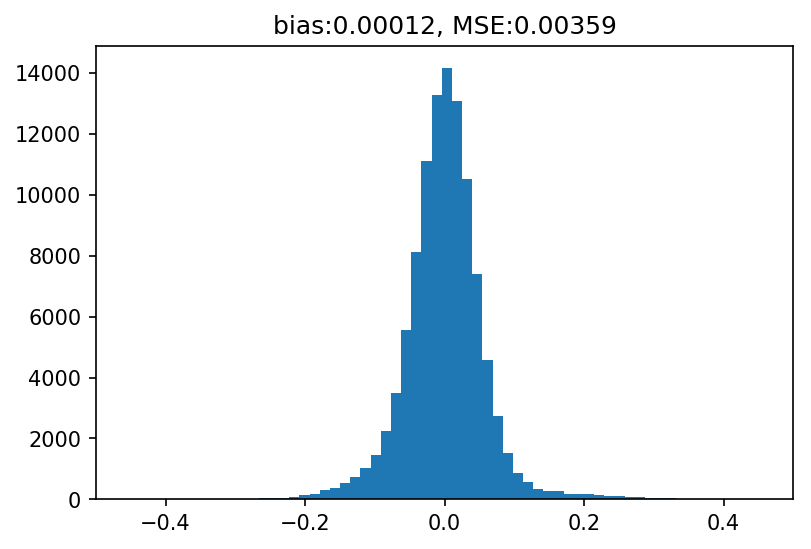

In [138]:
diff = y_pred-y_test
_ = pl.hist(diff, bins=100)
pl.xlim([-0.5,0.5])
pl.title("bias:{:6.5f}, MSE:{:4.5f}".format(np.mean(diff), np.std(diff)**2))



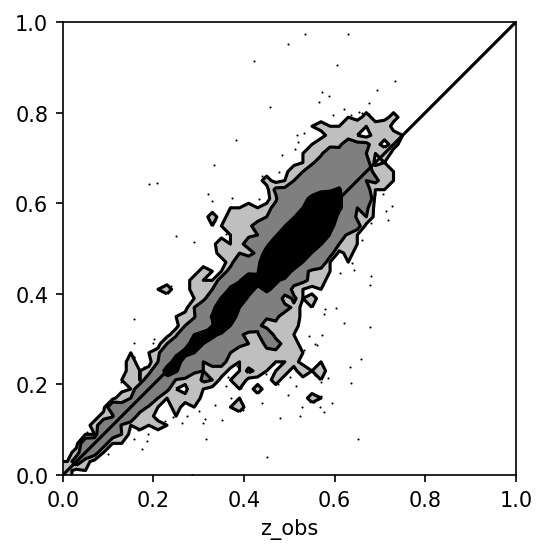

In [34]:
fig, ax = pl.subplots()
hist2d(y_pred,y_test,bins=50,ax=ax,range=[[0,1],[0,1]],levels=[0.68,0.95,0.997],plot_density=False,fill_contours=True,data_kwargs={'alpha':1,'marker':'.'})
ax.set_aspect('equal')
ax.set_xlabel("z_pred")
ax.set_xlabel("z_obs")
pl.plot([0,1],[0,1],'k-')

In [35]:
rf.feature_importances_

array([0.12050695, 0.02453066, 0.09370669, 0.75115154, 0.01010416])

In [36]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
mse_scorer = make_scorer(mean_squared_error)
dataset = load_boston()
X_full, y_full = dataset.data, dataset.target
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [37]:
estimator = RandomForestRegressor(random_state=0, n_estimators=100)
score = cross_val_score(estimator, X_full, y_full, scoring=mse_scorer).mean()
print("Score with the entire dataset = %.2f" % score)

Score with the entire dataset = 28.95
